# Assignment 0: Setup Test

Run this notebook to show us that you have successfully installed the libraries you need for this course.

If you get errors that you cannot solve, you're welcome to contact the TAs for help.

Important Note: **There is a Q&A session on Wednesday the 1st of October at 15:15 in room 6K1101/6K1107.** Everyone is free to attend and ask any questions regarding the setup process, Python, and/or the libraries we use.

In [39]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import torch
import imageio.v3 as iio
from feat import Detector
import furhat_remote_api
import transformers
import google.generativeai as genai
import os
import cv2
from PIL import Image, ImageDraw, ImageFont

In [40]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

# Remove warnings
PyFeat may throw (a lot of) warnings with newer versions of Python. Adding the following lines to your script will remove **all** its warnings.

**NOTE:** this may also remove useful warnings. If you see some bugs in your program it is advisable to comment the lines and look closely at the warnings.

In [41]:
import warnings

warnings.filterwarnings("ignore", module="feat")

If you want to achieve the same on a project level, you can set the following environmental variable. For example, in linux/macos:
```bash
export PYTHONWARNINGS="ignore:::feat"
```
In Windows:
```cmd
set PYTHONWARNINGS=ignore:::feat
```

# Image Analysis using Py-Feat

In [42]:
# Path setup
PROJECT_PATH = "/Users/abhinavramalingam/Documents/Uppsala/IID/Assignments/assignment_1/"
DATASET_DIRECTORY = PROJECT_PATH + 'dataset/'
OUTPUT_DIRECTORY = PROJECT_PATH + 'processed/'

image_dir = DATASET_DIRECTORY + 'images/'
annotations_file = DATASET_DIRECTORY + 'annotations.csv'

output_image_dir = OUTPUT_DIRECTORY + 'images/'
aus_csv = OUTPUT_DIRECTORY + 'aus.csv'
output_image_path = OUTPUT_DIRECTORY + 'au_visualization.png'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)

# Initialize Py-Feat detector
detector = Detector()

INFO:root:Loading Face model: retinaface
INFO:root:Loading Facial Landmark model: mobilefacenet
INFO:root:Loading facepose model: img2pose
INFO:root:Loading AU model: xgb
INFO:root:Loading emotion model: resmasknet


In [43]:
#Load annotation data
annotations_df = pd.read_csv(annotations_file)
annotations_df

,file,valence
0,thumbs-up,positive
1,sad-man,negative
2,claws,negative
3,laughing-couple,positive
4,by-the-sea,negative
5,arguing,negative
6,enjoying-the-sun,positive
7,piggyback,positive
8,back-off,negative
9,handshake,positive


In [44]:
# Initialize Py-Feat detector
face_model = "retinaface"
landmark_model = "mobilenet"
au_model = "xgb"
emotion_model = "resmasknet"
detector = Detector(face_model=face_model, landmark_model=landmark_model, au_model=au_model, emotion_model=emotion_model)

# Create a DataFrame to store AU activations
aus_data = []

INFO:root:Loading Face model: retinaface
INFO:root:Loading Facial Landmark model: mobilenet
INFO:root:Loading facepose model: img2pose
INFO:root:Loading AU model: xgb
INFO:root:Loading emotion model: resmasknet


In [45]:
def process_image(image_path, image_filename):
    image = Image.open(image_path)
    image_prediction = detector.detect_image(image_path, data_type="image")
    image_aus_data = []
    draw = ImageDraw.Draw(image)

    for i, row in image_prediction.iterrows():
        x, y, w, h = row[['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']]
        emotions = image_prediction.emotions.iloc[i]
        dominant_emotion = emotions.idxmax()
        caption_y = y - 30
        font = ImageFont.load_default()
        font_size = 48
        draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
        draw.text((x, caption_y), dominant_emotion, fill="red", font=font)
        face_aus = image_prediction.aus.iloc[i]

        for au_col, activation in face_aus.items():
            image_aus_data.append([image_filename, i, au_col, activation])

    output_image_path = os.path.join(output_image_dir, image_filename)
    image.save(output_image_path)

    return image_aus_data


In [46]:
# Function to accumulate AU activations across all images
def accumulate_aus_data():
    global aus_data
    # Iterate over all images in the dataset
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith(".jpg"):
            # Get the full path of the image
            image_path = os.path.join(image_dir, image_filename)

            # Process the image and accumulate AU data
            image_aus_data = process_image(image_path, image_filename)
            print(image_aus_data)

            # Append the AU data to the global list
            aus_data.extend(image_aus_data)

    # Save AU activations to CSV
    aus_df = pd.DataFrame(aus_data, columns=["file", "face", "AU", "activation"])
    aus_df.to_csv(aus_csv, index=False)

    print(f"AU activations saved to {aus_csv}")

In [47]:
# Run the accumulation process
accumulate_aus_data()

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 368, 368]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 124, 124]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


[['bullied.jpg', 0, 'AU01', 0.39273637533187866], ['bullied.jpg', 0, 'AU02', 0.1857738494873047], ['bullied.jpg', 0, 'AU04', 0.5543173551559448], ['bullied.jpg', 0, 'AU05', 0.31861960887908936], ['bullied.jpg', 0, 'AU06', 0.10936272144317627], ['bullied.jpg', 0, 'AU07', 0.0], ['bullied.jpg', 0, 'AU09', 0.16250933706760406], ['bullied.jpg', 0, 'AU10', 0.580166757106781], ['bullied.jpg', 0, 'AU11', 0.0], ['bullied.jpg', 0, 'AU12', 0.07369757443666458], ['bullied.jpg', 0, 'AU14', 0.4190942049026489], ['bullied.jpg', 0, 'AU15', 0.7679275870323181], ['bullied.jpg', 0, 'AU17', 0.4875350594520569], ['bullied.jpg', 0, 'AU20', 0.0], ['bullied.jpg', 0, 'AU23', 0.7604723572731018], ['bullied.jpg', 0, 'AU24', 0.7694656252861023], ['bullied.jpg', 0, 'AU25', 0.2201344221830368], ['bullied.jpg', 0, 'AU26', 0.11617220193147659], ['bullied.jpg', 0, 'AU28', 0.47218120098114014], ['bullied.jpg', 0, 'AU43', 0.044060297310352325], ['bullied.jpg', 1, 'AU01', 0.48832374811172485], ['bullied.jpg', 1, 'AU02', 

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 148, 148]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


[['sad-man.jpg', 0, 'AU01', 0.5877749919891357], ['sad-man.jpg', 0, 'AU02', 0.20319098234176636], ['sad-man.jpg', 0, 'AU04', 0.5935767889022827], ['sad-man.jpg', 0, 'AU05', 0.49377015233039856], ['sad-man.jpg', 0, 'AU06', 0.23969335854053497], ['sad-man.jpg', 0, 'AU07', 1.0], ['sad-man.jpg', 0, 'AU09', 0.3207281529903412], ['sad-man.jpg', 0, 'AU10', 0.022944459691643715], ['sad-man.jpg', 0, 'AU11', 1.0], ['sad-man.jpg', 0, 'AU12', 0.2063545137643814], ['sad-man.jpg', 0, 'AU14', 0.25315389037132263], ['sad-man.jpg', 0, 'AU15', 0.2633970081806183], ['sad-man.jpg', 0, 'AU17', 0.5141558647155762], ['sad-man.jpg', 0, 'AU20', 0.0], ['sad-man.jpg', 0, 'AU23', 0.583602249622345], ['sad-man.jpg', 0, 'AU24', 0.6428148746490479], ['sad-man.jpg', 0, 'AU25', 0.790894627571106], ['sad-man.jpg', 0, 'AU26', 0.5668383836746216], ['sad-man.jpg', 0, 'AU28', 0.0506126694381237], ['sad-man.jpg', 0, 'AU43', 0.43130406737327576]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 192, 192]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 146, 146]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


[['piggyback.jpg', 0, 'AU01', 0.6959397196769714], ['piggyback.jpg', 0, 'AU02', 0.42540106177330017], ['piggyback.jpg', 0, 'AU04', 0.4512251615524292], ['piggyback.jpg', 0, 'AU05', 0.3131083846092224], ['piggyback.jpg', 0, 'AU06', 0.8653048872947693], ['piggyback.jpg', 0, 'AU07', 1.0], ['piggyback.jpg', 0, 'AU09', 0.7271193861961365], ['piggyback.jpg', 0, 'AU10', 0.9444517493247986], ['piggyback.jpg', 0, 'AU11', 0.0], ['piggyback.jpg', 0, 'AU12', 0.8885590434074402], ['piggyback.jpg', 0, 'AU14', 0.528438150882721], ['piggyback.jpg', 0, 'AU15', 0.5152727365493774], ['piggyback.jpg', 0, 'AU17', 0.19220033288002014], ['piggyback.jpg', 0, 'AU20', 1.0], ['piggyback.jpg', 0, 'AU23', 0.13037629425525665], ['piggyback.jpg', 0, 'AU24', 0.010582484304904938], ['piggyback.jpg', 0, 'AU25', 0.9997454285621643], ['piggyback.jpg', 0, 'AU26', 0.5901827812194824], ['piggyback.jpg', 0, 'AU28', 0.15353912115097046], ['piggyback.jpg', 0, 'AU43', 0.4111601710319519], ['piggyback.jpg', 1, 'AU01', 0.36308464

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 88, 88]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 78, 78]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 72, 72]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 82, 82]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


[['students.jpg', 0, 'AU01', 0.49107277393341064], ['students.jpg', 0, 'AU02', 0.2280350774526596], ['students.jpg', 0, 'AU04', 0.7683106660842896], ['students.jpg', 0, 'AU05', 0.5001938343048096], ['students.jpg', 0, 'AU06', 0.05042749270796776], ['students.jpg', 0, 'AU07', 0.0], ['students.jpg', 0, 'AU09', 0.18243557214736938], ['students.jpg', 0, 'AU10', 0.0032647699117660522], ['students.jpg', 0, 'AU11', 1.0], ['students.jpg', 0, 'AU12', 0.017239101231098175], ['students.jpg', 0, 'AU14', 0.29781007766723633], ['students.jpg', 0, 'AU15', 0.6732549071311951], ['students.jpg', 0, 'AU17', 0.5407629013061523], ['students.jpg', 0, 'AU20', 0.0], ['students.jpg', 0, 'AU23', 0.576934814453125], ['students.jpg', 0, 'AU24', 0.6420626044273376], ['students.jpg', 0, 'AU25', 0.18495610356330872], ['students.jpg', 0, 'AU26', 0.1232987642288208], ['students.jpg', 0, 'AU28', 0.8067019581794739], ['students.jpg', 0, 'AU43', 0.05863798037171364], ['students.jpg', 1, 'AU01', 0.44736456871032715], ['st

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 252, 252]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 128, 128]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


[['arguing.jpg', 0, 'AU01', 0.2216278314590454], ['arguing.jpg', 0, 'AU02', 0.10262405872344971], ['arguing.jpg', 0, 'AU04', 0.2082243114709854], ['arguing.jpg', 0, 'AU05', 0.3558880686759949], ['arguing.jpg', 0, 'AU06', 0.05709357187151909], ['arguing.jpg', 0, 'AU07', 0.0], ['arguing.jpg', 0, 'AU09', 0.19782599806785583], ['arguing.jpg', 0, 'AU10', 0.002343391068279743], ['arguing.jpg', 0, 'AU11', 1.0], ['arguing.jpg', 0, 'AU12', 0.08775405585765839], ['arguing.jpg', 0, 'AU14', 0.5416494011878967], ['arguing.jpg', 0, 'AU15', 0.16964195668697357], ['arguing.jpg', 0, 'AU17', 0.25408053398132324], ['arguing.jpg', 0, 'AU20', 0.0], ['arguing.jpg', 0, 'AU23', 0.5714929699897766], ['arguing.jpg', 0, 'AU24', 0.6206585168838501], ['arguing.jpg', 0, 'AU25', 0.5413205623626709], ['arguing.jpg', 0, 'AU26', 0.2683136761188507], ['arguing.jpg', 0, 'AU28', 0.10606086999177933], ['arguing.jpg', 0, 'AU43', 0.06622330099344254], ['arguing.jpg', 1, 'AU01', 0.3945680260658264], ['arguing.jpg', 1, 'AU02',

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 206, 206]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


[['happy-man.jpg', 0, 'AU01', 0.5989091396331787], ['happy-man.jpg', 0, 'AU02', 0.5535712838172913], ['happy-man.jpg', 0, 'AU04', 0.21061637997627258], ['happy-man.jpg', 0, 'AU05', 0.31545186042785645], ['happy-man.jpg', 0, 'AU06', 0.9376656413078308], ['happy-man.jpg', 0, 'AU07', 1.0], ['happy-man.jpg', 0, 'AU09', 0.6258209347724915], ['happy-man.jpg', 0, 'AU10', 0.948785126209259], ['happy-man.jpg', 0, 'AU11', 1.0], ['happy-man.jpg', 0, 'AU12', 0.9820926189422607], ['happy-man.jpg', 0, 'AU14', 0.6781482100486755], ['happy-man.jpg', 0, 'AU15', 0.20449265837669373], ['happy-man.jpg', 0, 'AU17', 0.25845396518707275], ['happy-man.jpg', 0, 'AU20', 1.0], ['happy-man.jpg', 0, 'AU23', 0.11839087307453156], ['happy-man.jpg', 0, 'AU24', 0.018195118755102158], ['happy-man.jpg', 0, 'AU25', 0.9989930987358093], ['happy-man.jpg', 0, 'AU26', 0.6347811818122864], ['happy-man.jpg', 0, 'AU28', 0.13601809740066528], ['happy-man.jpg', 0, 'AU43', 0.24919889867305756]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 208, 208]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


[['bills.jpg', 0, 'AU01', 0.4130770266056061], ['bills.jpg', 0, 'AU02', 0.23292230069637299], ['bills.jpg', 0, 'AU04', 0.7577177286148071], ['bills.jpg', 0, 'AU05', 0.2615754008293152], ['bills.jpg', 0, 'AU06', 0.10463781654834747], ['bills.jpg', 0, 'AU07', 0.0], ['bills.jpg', 0, 'AU09', 0.24654799699783325], ['bills.jpg', 0, 'AU10', 0.0023041756357997656], ['bills.jpg', 0, 'AU11', 0.0], ['bills.jpg', 0, 'AU12', 0.03859753534197807], ['bills.jpg', 0, 'AU14', 0.3709820508956909], ['bills.jpg', 0, 'AU15', 0.4048478901386261], ['bills.jpg', 0, 'AU17', 0.3655816316604614], ['bills.jpg', 0, 'AU20', 0.0], ['bills.jpg', 0, 'AU23', 0.505584180355072], ['bills.jpg', 0, 'AU24', 0.6938533782958984], ['bills.jpg', 0, 'AU25', 0.0031870051752775908], ['bills.jpg', 0, 'AU26', 0.17794226109981537], ['bills.jpg', 0, 'AU28', 0.15768630802631378], ['bills.jpg', 0, 'AU43', 0.7994869947433472]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 150, 150]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


[['back-off.jpg', 0, 'AU01', 0.3135965168476105], ['back-off.jpg', 0, 'AU02', 0.21266382932662964], ['back-off.jpg', 0, 'AU04', 0.3005426228046417], ['back-off.jpg', 0, 'AU05', 0.5932855010032654], ['back-off.jpg', 0, 'AU06', 0.16143248975276947], ['back-off.jpg', 0, 'AU07', 0.0], ['back-off.jpg', 0, 'AU09', 0.1808457225561142], ['back-off.jpg', 0, 'AU10', 0.08647409081459045], ['back-off.jpg', 0, 'AU11', 1.0], ['back-off.jpg', 0, 'AU12', 0.16100555658340454], ['back-off.jpg', 0, 'AU14', 0.2810554504394531], ['back-off.jpg', 0, 'AU15', 0.24896708130836487], ['back-off.jpg', 0, 'AU17', 0.27300432324409485], ['back-off.jpg', 0, 'AU20', 1.0], ['back-off.jpg', 0, 'AU23', 0.20945380628108978], ['back-off.jpg', 0, 'AU24', 0.10082294791936874], ['back-off.jpg', 0, 'AU25', 0.9959348440170288], ['back-off.jpg', 0, 'AU26', 0.666486382484436], ['back-off.jpg', 0, 'AU28', 0.019612736999988556], ['back-off.jpg', 0, 'AU43', 0.058509428054094315]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 152, 152]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 166, 166]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 158, 158]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


[['grandparents.jpg', 0, 'AU01', 0.22475658357143402], ['grandparents.jpg', 0, 'AU02', 0.1782936155796051], ['grandparents.jpg', 0, 'AU04', 0.6995082497596741], ['grandparents.jpg', 0, 'AU05', 0.31313368678092957], ['grandparents.jpg', 0, 'AU06', 0.5712298154830933], ['grandparents.jpg', 0, 'AU07', 1.0], ['grandparents.jpg', 0, 'AU09', 0.47528567910194397], ['grandparents.jpg', 0, 'AU10', 0.3779431879520416], ['grandparents.jpg', 0, 'AU11', 0.0], ['grandparents.jpg', 0, 'AU12', 0.6250126361846924], ['grandparents.jpg', 0, 'AU14', 0.5226694941520691], ['grandparents.jpg', 0, 'AU15', 0.5144433975219727], ['grandparents.jpg', 0, 'AU17', 0.19655299186706543], ['grandparents.jpg', 0, 'AU20', 1.0], ['grandparents.jpg', 0, 'AU23', 0.38841232657432556], ['grandparents.jpg', 0, 'AU24', 0.030048908665776253], ['grandparents.jpg', 0, 'AU25', 0.9997077584266663], ['grandparents.jpg', 0, 'AU26', 0.7545084357261658], ['grandparents.jpg', 0, 'AU28', 0.05228801816701889], ['grandparents.jpg', 0, 'AU43

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 100, 100]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


[['enjoying-the-sun.jpg', 0, 'AU01', 0.429590106010437], ['enjoying-the-sun.jpg', 0, 'AU02', 0.39795708656311035], ['enjoying-the-sun.jpg', 0, 'AU04', 0.42786574363708496], ['enjoying-the-sun.jpg', 0, 'AU05', 0.39247652888298035], ['enjoying-the-sun.jpg', 0, 'AU06', 0.5552632808685303], ['enjoying-the-sun.jpg', 0, 'AU07', 1.0], ['enjoying-the-sun.jpg', 0, 'AU09', 0.31823959946632385], ['enjoying-the-sun.jpg', 0, 'AU10', 0.04299777373671532], ['enjoying-the-sun.jpg', 0, 'AU11', 1.0], ['enjoying-the-sun.jpg', 0, 'AU12', 0.698970377445221], ['enjoying-the-sun.jpg', 0, 'AU14', 0.5047162771224976], ['enjoying-the-sun.jpg', 0, 'AU15', 0.4414500296115875], ['enjoying-the-sun.jpg', 0, 'AU17', 0.5864760875701904], ['enjoying-the-sun.jpg', 0, 'AU20', 0.0], ['enjoying-the-sun.jpg', 0, 'AU23', 0.21433322131633759], ['enjoying-the-sun.jpg', 0, 'AU24', 0.6249411106109619], ['enjoying-the-sun.jpg', 0, 'AU25', 0.8293114304542542], ['enjoying-the-sun.jpg', 0, 'AU26', 0.18662004172801971], ['enjoying-th

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 244, 244]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


[['claws.jpg', 0, 'AU01', 0.34994325041770935], ['claws.jpg', 0, 'AU02', 0.11334684491157532], ['claws.jpg', 0, 'AU04', 0.9112145304679871], ['claws.jpg', 0, 'AU05', 0.326995849609375], ['claws.jpg', 0, 'AU06', 0.7668036222457886], ['claws.jpg', 0, 'AU07', 0.0], ['claws.jpg', 0, 'AU09', 0.5964849591255188], ['claws.jpg', 0, 'AU10', 0.8743411898612976], ['claws.jpg', 0, 'AU11', 1.0], ['claws.jpg', 0, 'AU12', 0.8088650107383728], ['claws.jpg', 0, 'AU14', 0.318075954914093], ['claws.jpg', 0, 'AU15', 0.43364641070365906], ['claws.jpg', 0, 'AU17', 0.18172040581703186], ['claws.jpg', 0, 'AU20', 1.0], ['claws.jpg', 0, 'AU23', 0.305865615606308], ['claws.jpg', 0, 'AU24', 0.007381541654467583], ['claws.jpg', 0, 'AU25', 0.9999122619628906], ['claws.jpg', 0, 'AU26', 0.910560131072998], ['claws.jpg', 0, 'AU28', 0.06239040940999985], ['claws.jpg', 0, 'AU43', 0.6047071814537048]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 296, 296]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 186, 186]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 164, 164]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


[['disagreement.jpg', 0, 'AU01', 0.42960381507873535], ['disagreement.jpg', 0, 'AU02', 0.22702093422412872], ['disagreement.jpg', 0, 'AU04', 0.18588823080062866], ['disagreement.jpg', 0, 'AU05', 0.5117543935775757], ['disagreement.jpg', 0, 'AU06', 0.08419865369796753], ['disagreement.jpg', 0, 'AU07', 0.0], ['disagreement.jpg', 0, 'AU09', 0.1057470515370369], ['disagreement.jpg', 0, 'AU10', 0.009922084398567677], ['disagreement.jpg', 0, 'AU11', 1.0], ['disagreement.jpg', 0, 'AU12', 0.05262422934174538], ['disagreement.jpg', 0, 'AU14', 0.20823895931243896], ['disagreement.jpg', 0, 'AU15', 0.295027494430542], ['disagreement.jpg', 0, 'AU17', 0.5172180533409119], ['disagreement.jpg', 0, 'AU20', 0.0], ['disagreement.jpg', 0, 'AU23', 0.2803226113319397], ['disagreement.jpg', 0, 'AU24', 0.5404667854309082], ['disagreement.jpg', 0, 'AU25', 0.3035600483417511], ['disagreement.jpg', 0, 'AU26', 0.28447386622428894], ['disagreement.jpg', 0, 'AU28', 0.04996877536177635], ['disagreement.jpg', 0, 'AU4

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 184, 184]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


[['tablet.jpg', 0, 'AU01', 0.30020052194595337], ['tablet.jpg', 0, 'AU02', 0.17610545456409454], ['tablet.jpg', 0, 'AU04', 0.22155646979808807], ['tablet.jpg', 0, 'AU05', 0.3273155689239502], ['tablet.jpg', 0, 'AU06', 0.09449571371078491], ['tablet.jpg', 0, 'AU07', 0.0], ['tablet.jpg', 0, 'AU09', 0.2627716064453125], ['tablet.jpg', 0, 'AU10', 0.012550568208098412], ['tablet.jpg', 0, 'AU11', 0.0], ['tablet.jpg', 0, 'AU12', 0.02782016061246395], ['tablet.jpg', 0, 'AU14', 0.3650006353855133], ['tablet.jpg', 0, 'AU15', 0.2565307319164276], ['tablet.jpg', 0, 'AU17', 0.6035744547843933], ['tablet.jpg', 0, 'AU20', 0.0], ['tablet.jpg', 0, 'AU23', 0.3664858639240265], ['tablet.jpg', 0, 'AU24', 0.5153616070747375], ['tablet.jpg', 0, 'AU25', 0.1014009639620781], ['tablet.jpg', 0, 'AU26', 0.21235163509845734], ['tablet.jpg', 0, 'AU28', 0.21517491340637207], ['tablet.jpg', 0, 'AU43', 0.29921987652778625]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 304, 304]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 161, 178]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 320, 320]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


[['laughing-couple.jpg', 0, 'AU01', 0.4963877201080322], ['laughing-couple.jpg', 0, 'AU02', 0.3907022476196289], ['laughing-couple.jpg', 0, 'AU04', 0.26191750168800354], ['laughing-couple.jpg', 0, 'AU05', 0.330649733543396], ['laughing-couple.jpg', 0, 'AU06', 0.8971043229103088], ['laughing-couple.jpg', 0, 'AU07', 1.0], ['laughing-couple.jpg', 0, 'AU09', 0.5665878653526306], ['laughing-couple.jpg', 0, 'AU10', 0.7933393120765686], ['laughing-couple.jpg', 0, 'AU11', 1.0], ['laughing-couple.jpg', 0, 'AU12', 0.9446300864219666], ['laughing-couple.jpg', 0, 'AU14', 0.5562630295753479], ['laughing-couple.jpg', 0, 'AU15', 0.4451640546321869], ['laughing-couple.jpg', 0, 'AU17', 0.40088436007499695], ['laughing-couple.jpg', 0, 'AU20', 0.0], ['laughing-couple.jpg', 0, 'AU23', 0.12202287465333939], ['laughing-couple.jpg', 0, 'AU24', 0.3148675858974457], ['laughing-couple.jpg', 0, 'AU25', 0.9368876218795776], ['laughing-couple.jpg', 0, 'AU26', 0.3718245029449463], ['laughing-couple.jpg', 0, 'AU28',

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 110, 110]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 130, 130]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 138, 138]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


[['handshake.jpg', 0, 'AU01', 0.5388705134391785], ['handshake.jpg', 0, 'AU02', 0.5618215203285217], ['handshake.jpg', 0, 'AU04', 0.30170339345932007], ['handshake.jpg', 0, 'AU05', 0.36397072672843933], ['handshake.jpg', 0, 'AU06', 0.8287466764450073], ['handshake.jpg', 0, 'AU07', 1.0], ['handshake.jpg', 0, 'AU09', 0.3852512240409851], ['handshake.jpg', 0, 'AU10', 0.9151821136474609], ['handshake.jpg', 0, 'AU11', 0.0], ['handshake.jpg', 0, 'AU12', 0.9588460922241211], ['handshake.jpg', 0, 'AU14', 0.3807957172393799], ['handshake.jpg', 0, 'AU15', 0.1995254009962082], ['handshake.jpg', 0, 'AU17', 0.20465371012687683], ['handshake.jpg', 0, 'AU20', 1.0], ['handshake.jpg', 0, 'AU23', 0.0632808580994606], ['handshake.jpg', 0, 'AU24', 0.016371911391615868], ['handshake.jpg', 0, 'AU25', 0.9995757937431335], ['handshake.jpg', 0, 'AU26', 0.40279024839401245], ['handshake.jpg', 0, 'AU28', 0.06229511275887489], ['handshake.jpg', 0, 'AU43', 0.07914460450410843], ['handshake.jpg', 1, 'AU01', 0.35333

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 236, 236]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


[['business.jpg', 0, 'AU01', 0.35558462142944336], ['business.jpg', 0, 'AU02', 0.35563427209854126], ['business.jpg', 0, 'AU04', 0.1472044438123703], ['business.jpg', 0, 'AU05', 0.37064415216445923], ['business.jpg', 0, 'AU06', 0.6328854560852051], ['business.jpg', 0, 'AU07', 1.0], ['business.jpg', 0, 'AU09', 0.18215960264205933], ['business.jpg', 0, 'AU10', 0.07175509631633759], ['business.jpg', 0, 'AU11', 1.0], ['business.jpg', 0, 'AU12', 0.6099954843521118], ['business.jpg', 0, 'AU14', 0.6709049940109253], ['business.jpg', 0, 'AU15', 0.4264216721057892], ['business.jpg', 0, 'AU17', 0.3083123564720154], ['business.jpg', 0, 'AU20', 1.0], ['business.jpg', 0, 'AU23', 0.18084576725959778], ['business.jpg', 0, 'AU24', 0.039070840924978256], ['business.jpg', 0, 'AU25', 0.9995765089988708], ['business.jpg', 0, 'AU26', 0.6675974130630493], ['business.jpg', 0, 'AU28', 0.015765607357025146], ['business.jpg', 0, 'AU43', 0.029613077640533447]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 66, 66]) to 224
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 68, 68]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


[['by-the-sea.jpg', 0, 'AU01', 0.29377415776252747], ['by-the-sea.jpg', 0, 'AU02', 0.13211946189403534], ['by-the-sea.jpg', 0, 'AU04', 0.2864017188549042], ['by-the-sea.jpg', 0, 'AU05', 0.36411264538764954], ['by-the-sea.jpg', 0, 'AU06', 0.15242911875247955], ['by-the-sea.jpg', 0, 'AU07', 0.0], ['by-the-sea.jpg', 0, 'AU09', 0.1967330276966095], ['by-the-sea.jpg', 0, 'AU10', 0.007468595635145903], ['by-the-sea.jpg', 0, 'AU11', 1.0], ['by-the-sea.jpg', 0, 'AU12', 0.06914373487234116], ['by-the-sea.jpg', 0, 'AU14', 0.6136190295219421], ['by-the-sea.jpg', 0, 'AU15', 0.14166943728923798], ['by-the-sea.jpg', 0, 'AU17', 0.4488012492656708], ['by-the-sea.jpg', 0, 'AU20', 1.0], ['by-the-sea.jpg', 0, 'AU23', 0.539498507976532], ['by-the-sea.jpg', 0, 'AU24', 0.4101690351963043], ['by-the-sea.jpg', 0, 'AU25', 0.8352324962615967], ['by-the-sea.jpg', 0, 'AU26', 0.681705117225647], ['by-the-sea.jpg', 0, 'AU28', 0.28383907675743103], ['by-the-sea.jpg', 0, 'AU43', 0.046278588473796844], ['by-the-sea.jp

  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 230, 230]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


[['sad-woman.jpg', 0, 'AU01', 0.6579921841621399], ['sad-woman.jpg', 0, 'AU02', 0.38422706723213196], ['sad-woman.jpg', 0, 'AU04', 0.5620293021202087], ['sad-woman.jpg', 0, 'AU05', 0.32548725605010986], ['sad-woman.jpg', 0, 'AU06', 0.13006100058555603], ['sad-woman.jpg', 0, 'AU07', 0.0], ['sad-woman.jpg', 0, 'AU09', 0.4672289490699768], ['sad-woman.jpg', 0, 'AU10', 0.0031101303175091743], ['sad-woman.jpg', 0, 'AU11', 1.0], ['sad-woman.jpg', 0, 'AU12', 0.034347064793109894], ['sad-woman.jpg', 0, 'AU14', 0.14253903925418854], ['sad-woman.jpg', 0, 'AU15', 0.16911281645298004], ['sad-woman.jpg', 0, 'AU17', 0.3652655780315399], ['sad-woman.jpg', 0, 'AU20', 0.0], ['sad-woman.jpg', 0, 'AU23', 0.2616240680217743], ['sad-woman.jpg', 0, 'AU24', 0.28384315967559814], ['sad-woman.jpg', 0, 'AU25', 0.8524283170700073], ['sad-woman.jpg', 0, 'AU26', 0.16988696157932281], ['sad-woman.jpg', 0, 'AU28', 0.26288196444511414], ['sad-woman.jpg', 0, 'AU43', 0.9334568381309509]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 130, 130]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


[['pain.jpg', 0, 'AU01', 0.3647659718990326], ['pain.jpg', 0, 'AU02', 0.5004557371139526], ['pain.jpg', 0, 'AU04', 0.3301972448825836], ['pain.jpg', 0, 'AU05', 0.5626022815704346], ['pain.jpg', 0, 'AU06', 0.473302960395813], ['pain.jpg', 0, 'AU07', 1.0], ['pain.jpg', 0, 'AU09', 0.4931095540523529], ['pain.jpg', 0, 'AU10', 0.08689876645803452], ['pain.jpg', 0, 'AU11', 1.0], ['pain.jpg', 0, 'AU12', 0.7709738612174988], ['pain.jpg', 0, 'AU14', 0.2978443205356598], ['pain.jpg', 0, 'AU15', 0.1025911197066307], ['pain.jpg', 0, 'AU17', 0.4142434895038605], ['pain.jpg', 0, 'AU20', 1.0], ['pain.jpg', 0, 'AU23', 0.5195438265800476], ['pain.jpg', 0, 'AU24', 0.3097265362739563], ['pain.jpg', 0, 'AU25', 0.5864964127540588], ['pain.jpg', 0, 'AU26', 0.3859492838382721], ['pain.jpg', 0, 'AU28', 0.10202829539775848], ['pain.jpg', 0, 'AU43', 0.820794403553009]]


  0%|          | 0/1 [00:00<?, ?it/s]INFO:root:detecting faces...
INFO:root:detecting landmarks...
INFO:root:RESCALING WARNING: image_operations.extract_face_from_bbox() is rescaling cropped img with shape torch.Size([3, 216, 216]) to 224
INFO:root:detecting poses...
INFO:root:detecting aus...
INFO:root:detecting emotions...
INFO:root:inverting face transform...
INFO:root:inverting landmark transform...
INFO:root:creating fex output...
100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

[['thumbs-up.jpg', 0, 'AU01', 0.1985481232404709], ['thumbs-up.jpg', 0, 'AU02', 0.3434540927410126], ['thumbs-up.jpg', 0, 'AU04', 0.2928028404712677], ['thumbs-up.jpg', 0, 'AU05', 0.23987628519535065], ['thumbs-up.jpg', 0, 'AU06', 0.9147592782974243], ['thumbs-up.jpg', 0, 'AU07', 1.0], ['thumbs-up.jpg', 0, 'AU09', 0.5588514804840088], ['thumbs-up.jpg', 0, 'AU10', 0.994485080242157], ['thumbs-up.jpg', 0, 'AU11', 0.0], ['thumbs-up.jpg', 0, 'AU12', 0.985139787197113], ['thumbs-up.jpg', 0, 'AU14', 0.6496606469154358], ['thumbs-up.jpg', 0, 'AU15', 0.04714541137218475], ['thumbs-up.jpg', 0, 'AU17', 0.1237591952085495], ['thumbs-up.jpg', 0, 'AU20', 1.0], ['thumbs-up.jpg', 0, 'AU23', 0.06226677447557449], ['thumbs-up.jpg', 0, 'AU24', 0.010595148429274559], ['thumbs-up.jpg', 0, 'AU25', 0.9997227787971497], ['thumbs-up.jpg', 0, 'AU26', 0.2815387547016144], ['thumbs-up.jpg', 0, 'AU28', 0.008937283419072628], ['thumbs-up.jpg', 0, 'AU43', 0.12767380475997925]]
AU activations saved to /Users/abhinav

# Feature Analysis and Visualisation

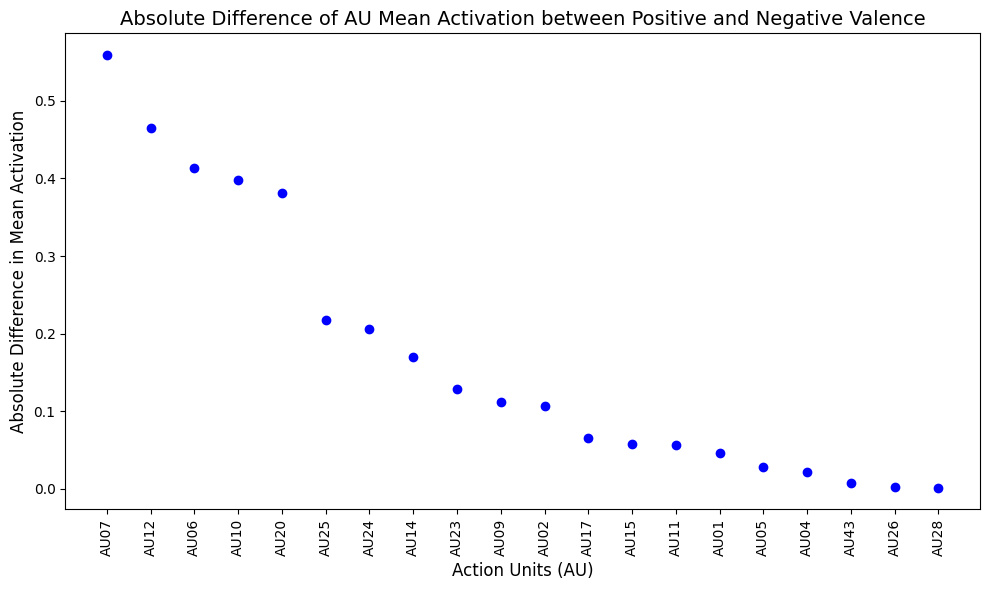

In [48]:
# Load the CSV files
annotations_df = pd.read_csv(annotations_file)
aus_df = pd.read_csv(aus_csv)

# Add '.jpg' extension to 'file' column in annotations_df for matching
annotations_df['file'] = annotations_df['file'] + '.jpg'

# Merge annotations with AU data based on the 'file' column
merged_df = pd.merge(aus_df, annotations_df, how='left', left_on='file', right_on='file')

# Separate the positive and negative conditions
positive_df = merged_df[merged_df['valence'] == 'positive']
negative_df = merged_df[merged_df['valence'] == 'negative']

# Calculate the mean value of each AU for both positive and negative conditions
positive_means = positive_df.groupby('AU')['activation'].mean()
negative_means = negative_df.groupby('AU')['activation'].mean()

# Calculate the absolute difference between positive and negative means
au_diff = abs(positive_means - negative_means)

# Sort the AU differences from biggest to smallest
sorted_au_diff = au_diff.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(sorted_au_diff.index, sorted_au_diff.values, color='blue', marker='o')  # scatter plot with individual points
plt.xlabel('Action Units (AU)', fontsize=12)
plt.ylabel('Absolute Difference in Mean Activation', fontsize=12)
plt.title('Absolute Difference of AU Mean Activation between Positive and Negative Valence', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(output_image_path)

# Display the plot
plt.show()


In [49]:
top_aus = sorted_au_diff.index.tolist()
top_aus

['AU07',
 'AU12',
 'AU06',
 'AU10',
 'AU20',
 'AU25',
 'AU24',
 'AU14',
 'AU23',
 'AU09',
 'AU02',
 'AU17',
 'AU15',
 'AU11',
 'AU01',
 'AU05',
 'AU04',
 'AU43',
 'AU26',
 'AU28']

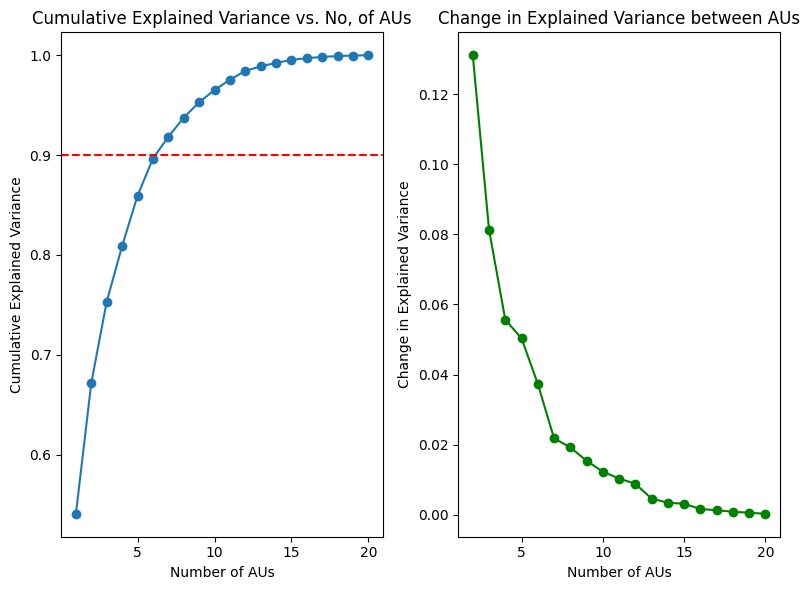

Select the top 11 AUs based on the explained variance leveling off.


In [50]:
aus_df = pd.read_csv(aus_csv)

# Pivot the dataframe to make each AU a separate column for each face in a file
# We'll group by file and face, and then use pivot to get AUs as columns
aus_pivot_df = aus_df.pivot_table(index=['file', 'face'], columns='AU', values='activation', aggfunc='mean')

# Handle missing values (if any) by filling with 0
aus_pivot_df = aus_pivot_df.fillna(0)

# Apply PCA to the AU activation data
pca = PCA()
pca.fit(aus_pivot_df)

# Calculate the cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Calculate the difference between consecutive cumulative variances to find where it levels off
variance_diff = np.diff(cumulative_variance)

# Plot the cumulative explained variance and its differences
plt.figure(figsize=(8, 6))

# Cumulative Variance Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.xlabel('Number of AUs')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. No, of AUs')

# Change in Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(2, len(cumulative_variance) + 1), variance_diff, marker='o', color='green')
plt.xlabel('Number of AUs')
plt.ylabel('Change in Explained Variance')
plt.title('Change in Explained Variance between AUs')

plt.tight_layout()
plt.show()

# Find the elbow point where the explained variance starts to level off
threshold = 0.01  # Define a threshold for change
elbow_point = np.argmax(variance_diff < threshold) + 1  # Add 1 because np.diff reduces length by 1

# Output the number of AUs to select
print(f"Select the top {elbow_point} AUs based on the explained variance leveling off.")